In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import geopandas as gpd
import re

from statsmodels.stats import diagnostic
from scipy import stats

In [95]:
PATH_RAW = '../data/raw/'
PATH_RES = '../res/'
names_m = ['Wikipedia ID', 'FB ID', 'Name', 'Release', 'Box_office', 'Runtime', 'Language', 'Countries', 'Genres']
df_movies = pd.read_csv(PATH_RAW + 'movie.metadata.tsv', sep='\t', names=names_m)
df_movies.head()

,Wikipedia ID,FB ID,Name,Release,Box_office,Runtime,Language,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [96]:
def clean_column_values(column):
    pattern = r'\"[^\"]+\": \"([^\"]+)\"'
    return column.apply(lambda x: ', '.join(re.findall(pattern, str(x))) if pd.notnull(x) else x)

df_movies['Language'] = clean_column_values(df_movies['Language'])
df_movies['Countries'] = clean_column_values(df_movies['Countries'])
df_movies['Genres'] = clean_column_values(df_movies['Genres'])

df_movies['Release'] = df_movies['Release'].str.strip()
df_movies['Release'] = df_movies['Release'].str.extract(r'(\d{4})')[0]
df_movies['Release'] = pd.to_numeric(df_movies['Release'], errors='coerce')


df_movies.head()

,Wikipedia ID,FB ID,Name,Release,Box_office,Runtime,Language,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,English Language,United States of America,"Mystery, Biographical film, Drama, Crime Drama"
2,28463795,/m/0crgdbh,Brun bitter,1988.0,NaN,83.0,Norwegian Language,Norway,"Crime Fiction, Drama"
3,9363483,/m/0285_cd,White Of The Eye,1987.0,NaN,110.0,English Language,United Kingdom,"Thriller, Erotic thriller, Psychological thriller"
4,261236,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,German Language,Germany,Drama


In [97]:

revenue_total_by_country = df_movies.groupby('Countries').agg(
    total_box_office=('Box_office', 'sum'),
    average_box_office=('Box_office', 'mean'),
    movie_count=('Box_office', 'count')
).reset_index()

print(revenue_total_by_country)

df_comedy = df_movies[df_movies['Genres'].str.contains('Comedy', na=False)]

df_comedy = df_comedy.dropna(subset=['Box_office', 'Countries'])

df_comedy = df_comedy.assign(Countries=df_comedy['Countries'].str.split(',')).explode('Countries')

revenue_comedy_by_country = df_comedy.groupby('Countries').agg(
    total_box_office=('Box_office', 'sum'),
    average_box_office=('Box_office', 'mean'),
    movie_count=('Box_office', 'count')
).reset_index()

print(revenue_comedy_by_country)

                                              Countries  total_box_office  \
0                                                            2.717623e+09   
1                                           Afghanistan      0.000000e+00   
2                  Afghanistan, Canada, India, Portugal      0.000000e+00   
3                                    Afghanistan, India      0.000000e+00   
4                           Afghanistan, Ireland, Japan      0.000000e+00   
...                                                 ...               ...   
2119                    Yugoslavia, West Germany, Italy      0.000000e+00   
2120  Yugoslavia, West Germany, United Kingdom, Germany      0.000000e+00   
2121                          Zambia, Australia, Sweden      0.000000e+00   
2122                                           Zimbabwe      0.000000e+00   
2123                                  Zimbabwe, Germany      0.000000e+00   

      average_box_office  movie_count  
0           1.955125e+07          1

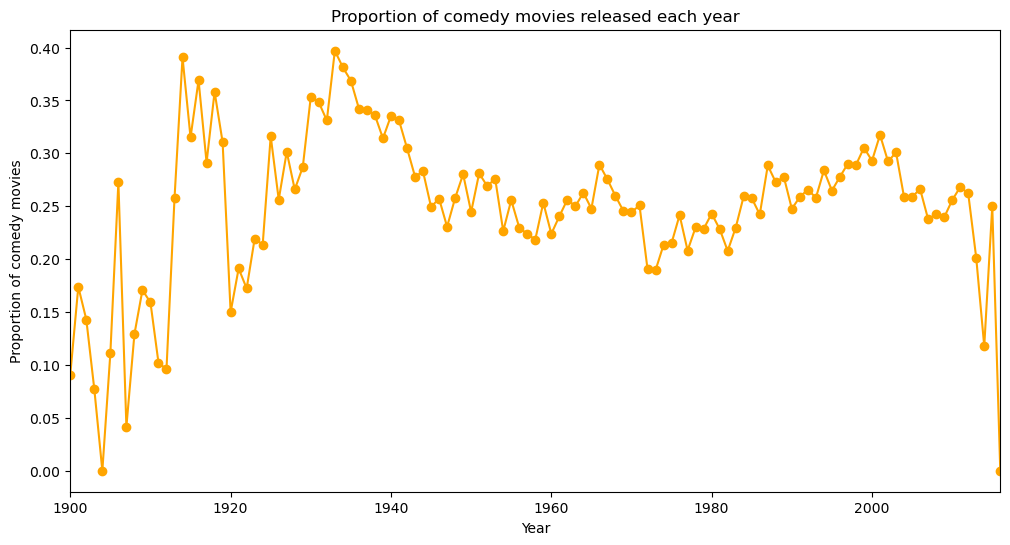

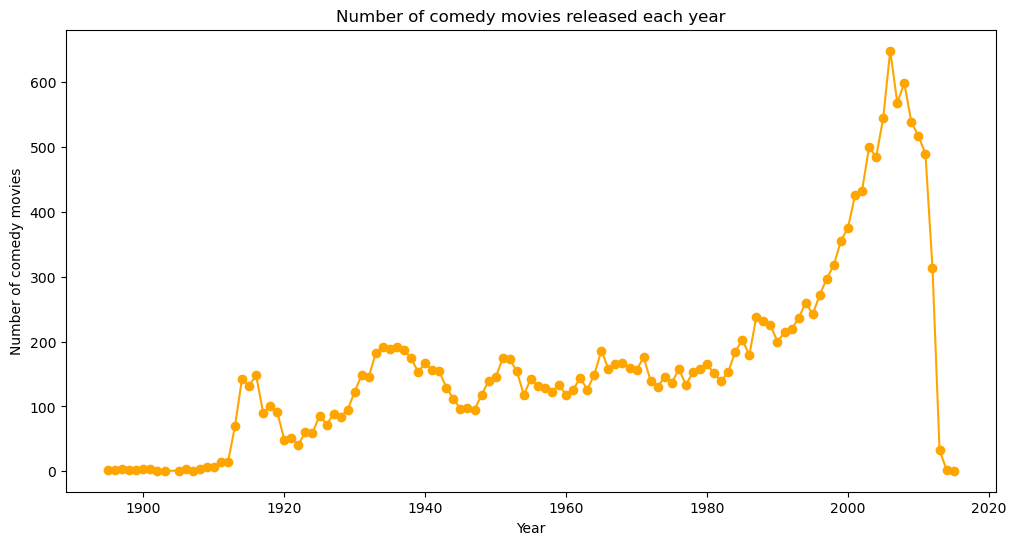

In [106]:
total_movies_per_year = df_movies.groupby('Release').size().reset_index(name='Total_movies')
df_comedy = df_movies[df_movies['Genres'].str.contains('Comedy', na=False)]
comedy_count_by_year = df_comedy.groupby('Release').size().reset_index(name='Comedy_count')

movies_per_year = pd.merge(total_movies_per_year, comedy_count_by_year, on='Release', how='left')
movies_per_year['Comedy_count'] = movies_per_year['Comedy_count'].fillna(0)

movies_per_year['Comedy_proportion'] = movies_per_year['Comedy_count'] / movies_per_year['Total_movies']

movies_per_year = movies_per_year[movies_per_year['Release'] >= 1900]

plt.figure(figsize=(12, 6))
plt.plot(movies_per_year['Release'], movies_per_year['Comedy_proportion'], marker='o', color='orange', linestyle='-')
plt.title('Proportion of comedy movies released each year')
plt.xlabel('Year')
plt.ylabel('Proportion of comedy movies')
plt.xlim(movies_per_year['Release'].min(), movies_per_year['Release'].max())

plt.figure(figsize=(12, 6))
plt.plot(comedy_count_by_year['Release'], comedy_count_by_year['Comedy_count'], marker='o', color='orange', linestyle='-')
plt.title('Number of comedy movies released each year')
plt.xlabel('Year')
plt.ylabel('Number of comedy movies')

plt.show()

In [99]:
df_exploded = df_movies.copy()  

df_exploded['Countries'] = df_exploded['Countries'].str.split(',')  
df_exploded = df_exploded.explode('Countries')  
df_exploded['Countries'] = df_exploded['Countries'].str.strip()
df_exploded['is comedy'] = df_exploded['Genres'].str.contains('Comedy', case=False, na=False)

country_movie_counts = df_exploded.groupby('Countries').agg(
    total_movies=('Countries', 'size'),
    comedy_movies=('is comedy', 'sum')
).reset_index()

print(country_movie_counts)

           Countries  total_movies  comedy_movies
0                             8154           1630
1        Afghanistan            15              0
2            Albania            28              4
3            Algeria            43              5
4          Argentina          1468            327
..               ...           ...            ...
143  Weimar Republic            68             10
144     West Germany           647            154
145       Yugoslavia           306             52
146           Zambia             3              0
147         Zimbabwe             8              2

[148 rows x 3 columns]


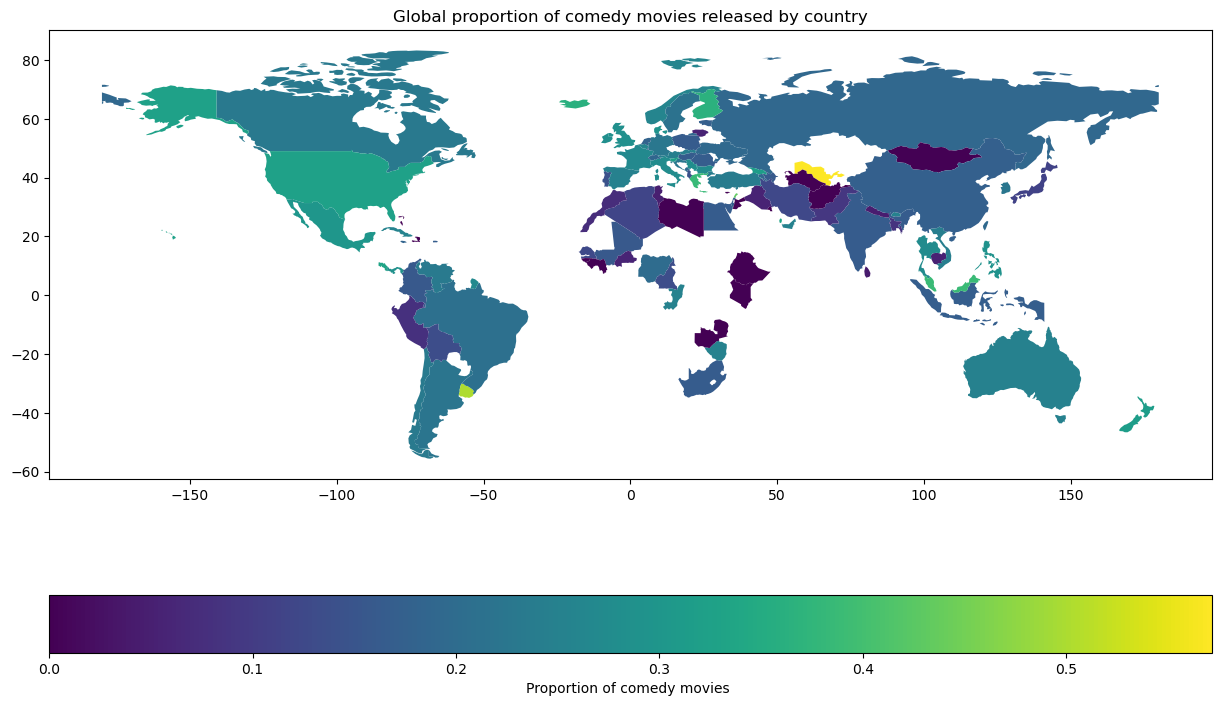

In [100]:
country_movie_counts['comedy_proportion'] = country_movie_counts['comedy_movies'] / country_movie_counts['total_movies']

world = gpd.read_file(PATH_RES + 'ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

world_comedy = world.set_index('NAME').join(country_movie_counts.set_index('Countries'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_comedy.plot(column='comedy_proportion', ax=ax, legend=True,
                 legend_kwds={'label': "Proportion of comedy movies ",
                              'orientation': "horizontal"})
plt.title('Global proportion of comedy movies released by country')
plt.show()

In [101]:
df_exploded = df_movies.copy()  
df_exploded['Countries'] = df_exploded['Countries'].str.split(',') 
df_exploded = df_exploded.explode('Countries') 
df_exploded['Countries'] = df_exploded['Countries'].str.strip()

revenue_total_by_country = df_exploded.groupby('Countries').agg(
    total_box_office=('Box_office', 'sum'),
).reset_index()

print(revenue_total_by_country)

df_comedy_exploded = df_movies[df_movies['Genres'].str.contains('Comedy', na=False)]
df_comedy_exploded['Countries'] = df_comedy_exploded['Countries'].str.split(',')  
df_comedy_exploded = df_comedy_exploded.explode('Countries') 

df_comedy_exploded['Countries'] = df_comedy_exploded['Countries'].str.strip()

revenue_comedy_by_country = df_comedy_exploded.groupby('Countries').agg(
    comedy_box_office=('Box_office', 'sum'),
).reset_index()

print(revenue_comedy_by_country)

revenue_proportion = revenue_total_by_country.merge(revenue_comedy_by_country)

print(revenue_proportion)


           Countries  total_box_office
0                         2.717623e+09
1        Afghanistan      1.015430e+05
2            Albania      0.000000e+00
3            Algeria      1.428330e+07
4          Argentina      4.078012e+08
..               ...               ...
143  Weimar Republic      7.798200e+04
144     West Germany      3.056178e+08
145       Yugoslavia      4.147788e+07
146           Zambia      0.000000e+00
147         Zimbabwe      1.815170e+07

[148 rows x 2 columns]
           Countries  comedy_box_office
0                           684492991.0
1            Albania                0.0
2            Algeria                0.0
3          Argentina         42275089.0
4            Armenia                0.0
..               ...                ...
113          Vietnam            64572.0
114  Weimar Republic                0.0
115     West Germany          8607763.0
116       Yugoslavia         13031948.0
117         Zimbabwe         18151699.0

[118 rows x 2 columns]
    

C:\Users\Removille\AppData\Local\Temp\ipykernel_22344\3262201731.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comedy_exploded['Countries'] = df_comedy_exploded['Countries'].str.split(',')


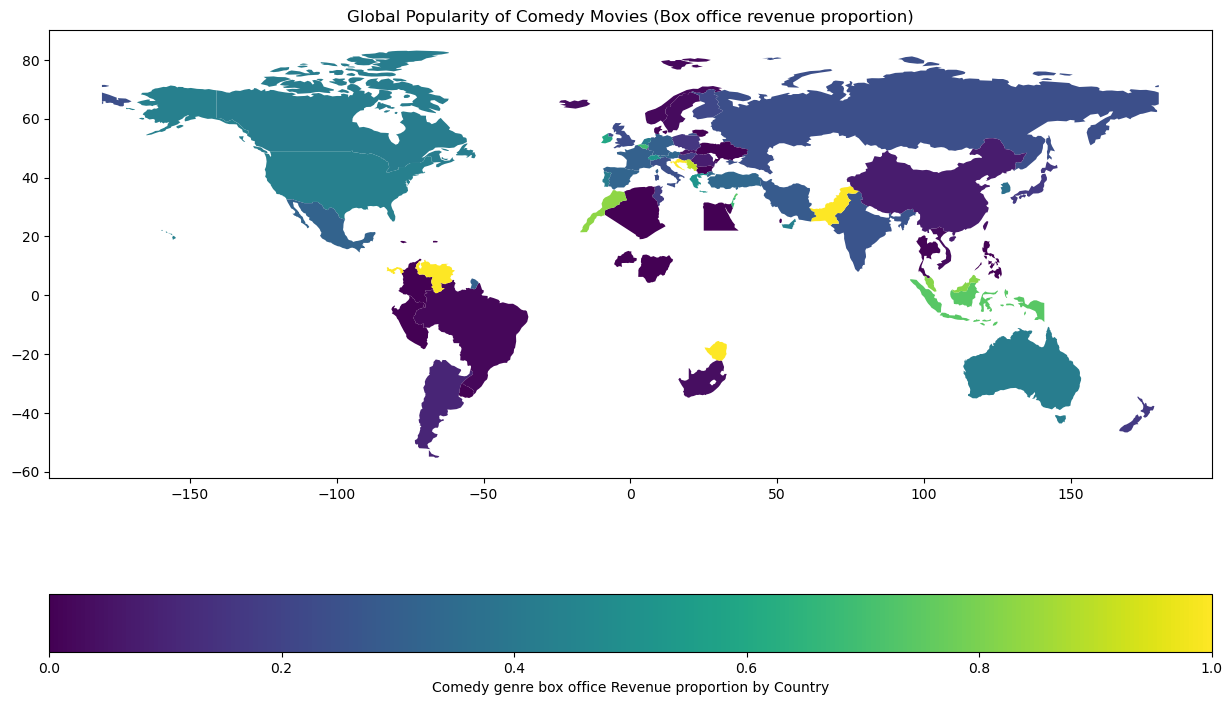

For the moment this analysis is incorrect since we do not have the revenue per country for each country and movie, but this is the idea for when we will use IMDB dataset


In [105]:

revenue_proportion['comedy_proportion'] = revenue_proportion['comedy_box_office'] / revenue_proportion['total_box_office']

world = gpd.read_file(PATH_RES + 'ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

world_comedy = world.set_index('NAME').join(revenue_proportion.set_index('Countries'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_comedy.plot(column='comedy_proportion', ax=ax, legend=True,
                 legend_kwds={'label': "Comedy genre box office Revenue proportion by Country",
                              'orientation': "horizontal"})
plt.title('Global Popularity of Comedy Movies (Box office revenue proportion)')
plt.show()

print('For the moment this analysis is incorrect since we do not have the revenue per country for each country and movie, but this is the idea for when we will use IMDB dataset')

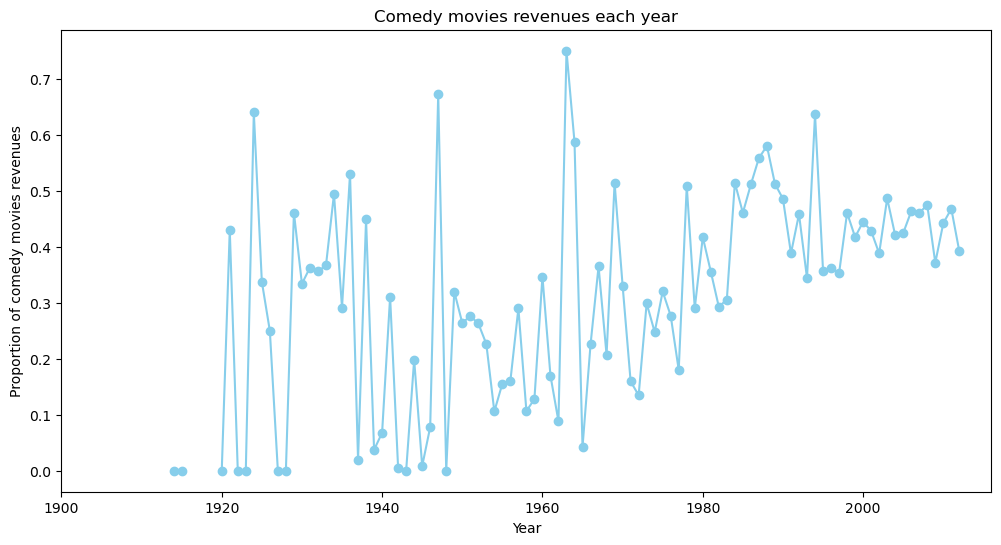

We will do a regression analysis because it looks like there is an trend going up throughout the year


In [103]:
total_revenues_per_year = df_movies.groupby('Release')['Box_office'].sum().reset_index(name='Total_revenues')
df_comedy = df_movies[df_movies['Genres'].str.contains('Comedy', na=False)]
comedy_revenues_by_year = df_comedy.groupby('Release')['Box_office'].sum().reset_index(name='Comedy_revenues')

revenues_per_year = pd.merge(total_revenues_per_year, comedy_revenues_by_year, on='Release', how='left')
revenues_per_year['Comedy_revenues'] = revenues_per_year['Comedy_revenues'].fillna(0)
revenues_per_year['Comedy_revenues'] = revenues_per_year['Comedy_revenues'] / revenues_per_year['Total_revenues']

# Filter
revenues_per_year = revenues_per_year[revenues_per_year['Release'] >= 1900]

plt.figure(figsize=(12, 6))
plt.plot(revenues_per_year['Release'], revenues_per_year['Comedy_revenues'], marker='o', color='skyblue', linestyle='-')
plt.title('Comedy movies revenues each year')
plt.xlabel('Year')
plt.ylabel('Proportion of comedy movies revenues')
plt.xlim(revenues_per_year['Release'].min(), revenues_per_year['Release'].max())

plt.show()

print('We will do a regression analysis because it looks like there is an trend going up throughout the year')

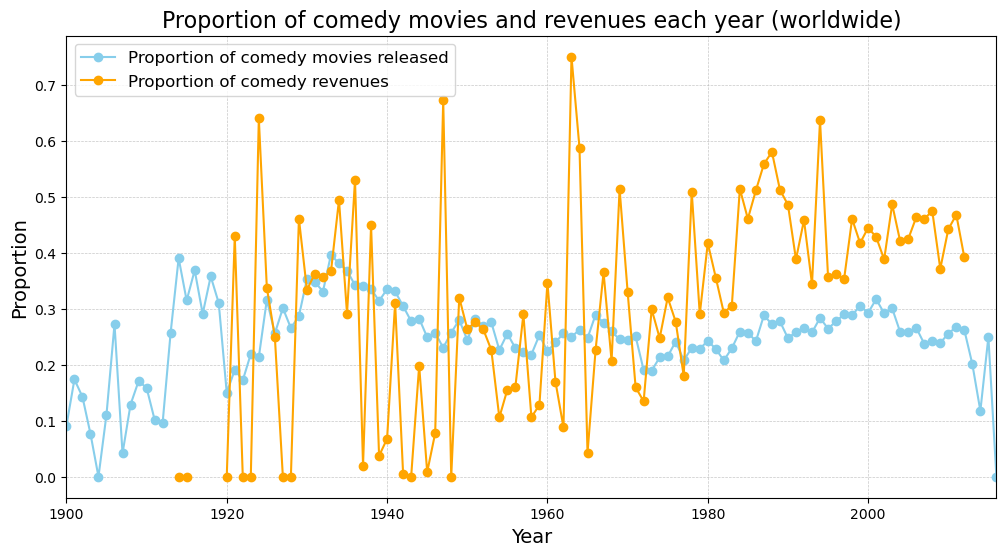

In [104]:
plt.figure(figsize=(12, 6))

plt.plot(movies_per_year['Release'], movies_per_year['Comedy_proportion'], 
         marker='o', color='skyblue', linestyle='-', label='Proportion of comedy movies released')
plt.plot(revenues_per_year['Release'], revenues_per_year['Comedy_revenues'], 
         marker='o', color='orange', linestyle='-', label='Proportion of comedy revenues')

plt.title('Proportion of comedy movies and revenues each year (worldwide)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.xlim(movies_per_year['Release'].min(), movies_per_year['Release'].max())

plt.show()